# monte-carlo opr probability modelling

The idea here is to use a monte-carlo simulation to skip the need of passing through model confidence/distribution information during a prediction process.
This allows for more complicated models to be used (ex: neural nets) without geting into gross math.

The general structure of what I'm thinking of is below:

Match data -> calculate team metric vector (component OPRs distributions) -> sample from metric vector distributions to feed into model -> run monte carlo on model to simulate outcomes -> reconstruct new distribution and make predictions

In [2]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import math
import sklearn

from os import listdir
from os.path import isfile, join
import random

from collections import defaultdict

from src.data_loader import *
from src.stat_utils import perform_regression
import src.modelling

sns.set_style('whitegrid')

data_folder = "data/"

## gather match data / calculate team metric vectors

I'm not worried about doing full event simulations, I just want to get enough info to calculate the OPR distribution vectors.

This logic (including calculating the OPR distributions) is already implemented in dataLoader.py. I'll need to do some amount of refactoring to do event simulations

In [3]:
# assumes that data has been preprocessed already. look at rebirth for more

qualification_matches = pd.read_csv(f'{data_folder}/cache/qualification-matches.csv')
team_scores = pd.read_csv(f'{data_folder}/cache/team-scores.csv')
team_data = pd.read_csv(f'{data_folder}/cache/team-data.csv')
team_component_opr = pd.read_csv(f'{data_folder}/cache/team-component-opr.csv')

teams_rated = set(team_component_opr['team_key'])

# one extra thing for this model: ignore qualification matches where not all teams have oprs
qualification_matches = qualification_matches[
    qualification_matches['blue_1_key'].isin(teams_rated) &
    qualification_matches['blue_2_key'].isin(teams_rated) &
    qualification_matches['blue_3_key'].isin(teams_rated) &

    qualification_matches['red_1_key'].isin(teams_rated) &
    qualification_matches['red_2_key'].isin(teams_rated) &
    qualification_matches['red_3_key'].isin(teams_rated)
    ]

# an example team metric vector
# team_component_opr.at[1971, 'mean_endgame'] = 4
# team_component_opr.at[1971, 'points_scored'] = 12
# team_component_opr.at[1971, 'cargo_lower_teleop'] = 6
team_component_opr[team_component_opr["team_key"] == "frc4522"] # TODO test impact on preds

,Unnamed: 0,team_key,matches_played,points_scored,points_scored_std,piece_low_auto,piece_low_auto_std,piece_mid_auto,piece_mid_auto_std,piece_high_auto,...,piece_mid_teleop_std,piece_high_teleop,piece_high_teleop_std,mean_links_scored,mean_links_scored_std,mean_auto_mobility,mean_auto_mobility_std,mean_endgame_park,mean_endgame_park_std,mean_score
988,988,frc4522,12,56.049175,14.833559,0.561946,0.664813,0.490713,0.408803,1.30378,...,1.921613,4.566391,2.249048,2.916667,1.320248,2.75,0.829156,5.666667,1.105542,105.583333


## sample from metric vector for model

This part is a bit more complicated. We basically need a way to sample from the team metric vector to feed real numbers into the model.

There are two ways of doing this that come to mind. Either:
- Sample each part of the vector independently
- Sample each part of the vector using a shared "percentile"

The second intuitively feels more realistic, however is probably not the way to go because it seems better to have more parameters per team.

In [6]:
# we only care about cells here, this should be updated.
# score_features = [i for sl in 
#     [[f"{s}_teleop", f"{s}_auto"] for s in ["cargo_lower", "cargo_upper"]]
#     for i in sl] + ["mean_endgame"]

score_features = ["mean_links_scored", "piece_low_auto", "piece_mid_auto", "piece_high_auto", "piece_low_teleop", "piece_mid_teleop", "piece_high_teleop", "mean_auto_mobility", "mean_endgame_park"]

rng = np.random.default_rng()

def sample_team_vectors(team_key, samples=1):
    comp_oprs = team_component_opr[team_component_opr["team_key"] == team_key]
    means_vec = [float(comp_oprs[f"{i}"].iloc[0]) for i in score_features]
    stds_vec = [float(comp_oprs[f"{i}_std"].iloc[0]) for i in score_features]

    sampled_vals = []
    for feature_idx in range(len(score_features)):
        vals = rng.normal(size=samples, loc=means_vec[feature_idx], scale=stds_vec[feature_idx])
        sampled_vals.append(vals)
    return sampled_vals

sample_team_vectors('frc4522', 3)

[array([5.0425571 , 4.48292899, 1.4930741 ]),
 array([0.08886614, 0.0491098 , 1.11144578]),
 array([0.44716106, 0.07458772, 0.72942691]),
 array([1.0148752 , 1.33770229, 0.88830115]),
 array([-0.28463129, -0.89764036,  0.84722995]),
 array([6.59970516, 0.22029112, 3.31867242]),
 array([9.55258292, 8.60100879, 2.70667939]),
 array([2.27287494, 3.7673377 , 2.81564075]),
 array([7.57216734, 4.30986522, 5.64474269])]

## generating test data

With a way to sample a team's performance, we now sample each team's distribution for each match and grab the outcome.
This will be used as training data for some kind of model.

We'll have 3 vectors produced for each match, each with their own outcome
- red_team:red_score 
- blue_team:blue_score
- red+blue_team:score_difference (red-blue)

each x_team vector is not flattened.

For the purpose of the models I immediately have in mind, only the 1st two matter (team score prediction), but the third could be useful later

In [8]:
rng = np.random.default_rng()

def sample_match(match_key, samples=1, qualification_matches=qualification_matches, played=True):
    match_data = qualification_matches[qualification_matches["match_key"] == match_key].iloc[0]

    def _get_outcome_color(color):
        team_keys = [match_data[f"{color}_{n+1}_key"] for n in range(3)]
        sampled_teams = []
        for team_key in team_keys:
            sampled_teams += [sample_team_vectors(team_key, samples)]# for team_key in team_keys]
        if played:
            outcome = match_data[f"{color}_points_scored"]
        else:
            outcome = -1
        return sampled_teams, outcome

    red, red_score = _get_outcome_color("red")
    blue, blue_score = _get_outcome_color("blue")
    return (red, red_score), (blue, blue_score), (red+blue, red_score-blue_score)

sample_match("2023arli_qm1", samples=3)

def sample_match_alliances(red_alliance, blue_alliance, samples=1):
    match_data = {
        "red_1_key": red_alliance[0],
        "red_2_key": red_alliance[1],
        "red_3_key": red_alliance[2],

        "blue_1_key": blue_alliance[0],
        "blue_2_key": blue_alliance[1],
        "blue_3_key": blue_alliance[2],
    }

    def _get_outcome_color(color):
        team_keys = [match_data[f"{color}_{n+1}_key"] for n in range(3)]
        sampled_teams = []
        for team_key in team_keys:
            sampled_teams += [sample_team_vectors(team_key, samples)]# for team_key in team_keys]
        return sampled_teams, -1

    return _get_outcome_color("red"), _get_outcome_color("blue")

# sample_match_alliances(["frc1533", "frc4795", "frc8757"], ["frc3459", "frc5518", "frc2059"])

(([[array([2.27186758, 0.58368133, 3.22914998]), array([-0.05627219,  0.20460489,  0.16490556]), array([ 0.05949087, -0.49228508,  0.46977519]), array([1.31077673, 1.68978855, 1.57256948]), array([3.21460418, 0.22605144, 0.82342965]), array([3.02213284, 1.9803511 , 0.09023429]), array([4.26721437, 3.67408364, 2.81353826]), array([3., 3., 3.]), array([0.8842881 , 4.86013872, 6.75603835])], [array([3.04132581, 2.0646205 , 2.00279621]), array([0.43036468, 1.23130852, 0.54824803]), array([-0.01691599, -0.1856399 ,  0.0478801 ]), array([ 0.15856419, -0.25178922, -0.42514536]), array([2.35113936, 1.96038954, 5.81906789]), array([ 1.12608221, -2.0077332 ,  1.97299082]), array([1.46527643, 2.04192642, 1.20508117]), array([0., 0., 0.]), array([ 3.60105566, -0.14665227,  5.434078  ])], [array([-0.34718849,  2.19067614,  1.83861137]), array([-0.05021382,  0.66607297,  0.17429216]), array([ 0.00732265, -0.02210502,  0.268273  ]), array([1.33691283, 1.42493125, 1.09949793]), array([-0.52902881,  0.

## Modelling and Training

For the sake of testing, I want to feed this into a basic linear regression model (the interface will be described below in code)

This can be swapped out easily with other models assuming they use the same interface.

Training data is assumed to be a flattened array of team:score data coming out of sample_match

In [80]:
samples = 100
matches_training = [sample_match(match_key, samples) for match_key in qualification_matches["match_key"]]

In [81]:
def flatten_training_data(training_data):
    xs = []
    ys = []
    for sampled_match in training_data:
        team_vectors, score = sampled_match
        for sample in range(np.shape(team_vectors)[2]):
            team_vec_flat = []
            for feature in range(np.shape(team_vectors)[1]):
                for member in range(3):
                    team_vec_flat.append(team_vectors[member][feature][sample])
            xs.append(team_vec_flat)
            ys.append(score)
    return xs, ys

class LinearRegressionModel:
    def __init__(self):
        self.reg = None

    def train(self, training_data):
        self.reg = sklearn.linear_model.LinearRegression()
        xs, ys = flatten_training_data(training_data)
        self.reg.fit(xs, ys)
    
    def predict(self, team_vectors):
        return self.reg.predict(team_vectors)

m = LinearRegressionModel()
train_in = []
for match in matches_training:
    red, blue, _ = match
    train_in.append(red)
    train_in.append(blue)
m.train(train_in)
predictions = m.predict(flatten_training_data(train_in)[0])

/home/valis/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


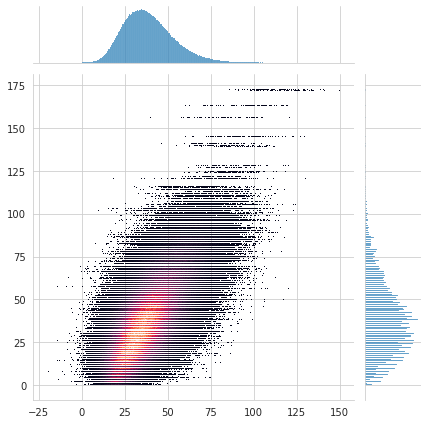

In [82]:
sns.jointplot(predictions, flatten_training_data(train_in)[1], kind='hist', cmap='rocket')

let's just like... predict events lmao.

In [83]:
# for unplayed matches
# event_key = 'week4/2022ncgui'

# qualifiers, unplayed, team_scores, team_data, _ = load_data_event(event_key)

qualifiers = qualification_matches

m_keys = []
red_wins = []
blue_wins = []
m_winners = []

for _, match in qualifiers.iterrows():
    red, blue, _ = sample_match(match['match_key'], 100, qualification_matches=qualifiers)
    r_pred = m.predict(flatten_training_data([red])[0])
    b_pred = m.predict(flatten_training_data([blue])[0])
    r_wins = 0
    b_wins = 0
    for k in range(len(r_pred)):
        if r_pred[k] > b_pred[k]:
            r_wins += 1
        else:
            b_wins += 1
    m_keys.append(match['match_key'])
    red_wins.append(r_wins)
    blue_wins.append(b_wins)
    m_winners.append('red' if match['red_points_scored'] > match['blue_points_scored'] else 'blue')

pred_matches = pd.DataFrame({
    "match_key": m_keys,
    "pred_red_wins": red_wins,
    "pred_blue_wins": blue_wins,
    "actual_winner": m_winners
})

# guesstimate accuracy
pred_matches['prob_red_win'] = pred_matches.apply(lambda row: row.pred_red_wins / (row.pred_red_wins + row.pred_blue_wins), axis=1)
bss = []
correct = 0
total = 0
for _, match in pred_matches.iterrows():
    if match['prob_red_win'] > 0.5 and match['actual_winner'] == 'red':
        bss.append((match['prob_red_win'] - 1)**2)
        correct += 1
    elif match['prob_red_win'] < 0.5 and match['actual_winner'] == 'blue':
        bss.append(((1 - match['prob_red_win']) - 1)**2)
        correct += 1
    else:
        bss.append((match['prob_red_win'] - 0)**2)
    total += 1
print(sum(bss) / len(bss))
print(correct / total)
pred_matches

0.0970027419034373
0.8289290681502086


,match_key,pred_red_wins,pred_blue_wins,actual_winner,prob_red_win
0,2022isde1_qm1,5,95,blue,0.05
1,2022isde1_qm10,3,97,blue,0.03
2,2022isde1_qm11,40,60,blue,0.40
3,2022isde1_qm12,55,45,red,0.55
4,2022isde1_qm13,86,14,red,0.86
...,...,...,...,...,...
5028,2022cada_qm55,31,69,blue,0.31
5029,2022cada_qm6,94,6,red,0.94
5030,2022cada_qm7,25,75,blue,0.25
5031,2022cada_qm8,1,99,blue,0.01


In [ ]:
# for unplayed matches
event_key = 'week4/2022ncgui'

qualifiers, unplayed, team_scores, team_data, _ = load_data_event(event_key)

m_keys = []
red_wins = []
blue_wins = []

for _, match in unplayed.iterrows():
    try:
        red, blue, _ = sample_match(match['match_key'], 100, qualification_matches=unplayed, played=False)
        r_pred = m.predict(flatten_training_data([red])[0])
        b_pred = m.predict(flatten_training_data([blue])[0])
        r_wins = 0
        b_wins = 0
        for k in range(len(r_pred)):
            if r_pred[k] > b_pred[k]:
                r_wins += 1
            else:
                b_wins += 1
        m_keys.append(match['match_key'])
        red_wins.append(r_wins)
        blue_wins.append(b_wins)
    except IndexError:
        pass

pred_matches = pd.DataFrame({
    "match_key": m_keys,
    "pred_red_wins": red_wins,
    "pred_blue_wins": blue_wins
})
pred_matches['prob_red_win'] = pred_matches.apply(
    lambda row: row.pred_red_wins / (row.pred_red_wins + row.pred_blue_wins),
    axis=1)
pred_matches

In [ ]:
teams_caring = ['frc5160']
print("MATCH PREDICTION READOUTS")
for team in teams_caring:
    matches_played_red = unplayed.loc[
        (team == unplayed["red_1_key"]) |
        (team == unplayed["red_2_key"]) |
        (team == unplayed["red_3_key"])]
    matches_r = pred_matches.loc[pred_matches['match_key'].isin(matches_played_red['match_key'])]
    matches_r['prob_win'] = matches_r['prob_red_win']
    matches_r = matches_r[['match_key', 'prob_win']]

    matches_played_blue = unplayed.loc[
        (team == unplayed["blue_1_key"]) |
        (team == unplayed["blue_2_key"]) |
        (team == unplayed["blue_3_key"])]
    matches_b = pred_matches.loc[pred_matches['match_key'].isin(matches_played_blue['match_key'])]
    matches_b['prob_win'] = 1-matches_b['prob_red_win']
    matches_b = matches_b[['match_key', 'prob_win']]
    matches_rel = pd.concat([matches_r, matches_b])
    print(f"TEAM {team}")
    print(matches_rel.sort_values('match_key'))
    # print(matches_rel)

In [ ]:
# get team win rates
matches_scorable = unplayed.loc[unplayed['match_key'].isin(pred_matches['match_key'])]
teams_scorable = pd.concat([matches_scorable[i] for i in ['red_1_key', 'red_2_key', 'red_3_key', 'blue_1_key', 'blue_2_key', 'blue_3_key']])
teams_caring = set(teams_scorable)
team_ks = []
team_expected_wins = []
for team in teams_caring:
    matches_played_red = unplayed.loc[
        (team == unplayed["red_1_key"]) |
        (team == unplayed["red_2_key"]) |
        (team == unplayed["red_3_key"])]
    matches_r = pred_matches.loc[pred_matches['match_key'].isin(matches_played_red['match_key'])]
    matches_r['prob_win'] = matches_r['prob_red_win']
    matches_r = matches_r[['match_key', 'prob_win']]

    matches_played_blue = unplayed.loc[
        (team == unplayed["blue_1_key"]) |
        (team == unplayed["blue_2_key"]) |
        (team == unplayed["blue_3_key"])]
    matches_b = pred_matches.loc[pred_matches['match_key'].isin(matches_played_blue['match_key'])]
    matches_b['prob_win'] = 1-matches_b['prob_red_win']
    matches_b = matches_b[['match_key', 'prob_win']]
    matches_rel = pd.concat([matches_r, matches_b])
    team_ks.append(team)
    team_expected_wins.append(sum([1 for i in matches_rel['prob_win'] if i > 0.5]))
    # team_expected_wins.append(sum(matches_rel['prob_win']))

event_predictions = pd.DataFrame({
    "team_key": team_ks,
    "expected_wins": team_expected_wins
})
event_predictions = event_predictions.sort_values('expected_wins')[::-1]
# event_predictions

/tmp/ipykernel_2791/855418576.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_r['prob_win'] = matches_r['prob_red_win']
/tmp/ipykernel_2791/855418576.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_b['prob_win'] = 1-matches_b['prob_red_win']
/tmp/ipykernel_2791/855418576.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [ ]:
# adjusted event predictions w/ previous wins
updating = {"team_key": [], "previous_wins": []}
for team in event_predictions['team_key']:
    adj_wins = 0
    for _, red_qualifier in qualifiers.loc[
        (team == qualifiers['red_1_key']) | (team == qualifiers['red_2_key']) | (team == qualifiers['red_3_key'])
    ].iterrows():
        if red_qualifier['red_points_scored'] > red_qualifier['blue_points_scored']:
            adj_wins += 1
    for _, blue_qualifier in qualifiers.loc[
        (team == qualifiers['blue_1_key']) | (team == qualifiers['blue_2_key']) | (team == qualifiers['blue_3_key'])
    ].iterrows():
        if blue_qualifier['blue_points_scored'] > blue_qualifier['red_points_scored']:
            adj_wins += 1
    updating["team_key"].append(team)
    updating["previous_wins"].append(adj_wins)
event_predictions = pd.merge(event_predictions, pd.DataFrame(updating))
event_predictions['total_wins'] = event_predictions['expected_wins'] + event_predictions['previous_wins']
event_predictions.sort_values('total_wins')[::-1]

,team_key,expected_wins,previous_wins,total_wins
5,frc4795,2,10,12
13,frc6500,1,9,10
1,frc7890,3,7,10
7,frc5190,2,7,9
20,frc2640,1,8,9
0,frc587,3,5,8
4,frc1533,2,6,8
6,frc2655,2,6,8
21,frc4561,1,6,7
11,frc5518,2,5,7


In [120]:
# let's simulate finals and predict which alliance will come out on top
alliances = [
    ['frc4795', 'frc1533', 'frc8757'],
    ['frc6500', 'frc5727', 'frc5160'],
    ['frc7890', 'frc6502', 'frc5607'],
    ['frc5190', 'frc2655', 'frc8429'],
    ['frc587', 'frc4561', 'frc8746'],
    ['frc2640', 'frc4829', 'frc5679'],
    ['frc8634', 'frc7443', 'frc8304'],
    ['frc5518', 'frc3459', 'frc2059']
]

match_stack = {
    "a": [1,8],
    "b": [4,5],
    "c": [3,6],
    "d": [2,7],
    "e": ["a", "b"],
    "f": ["c", "d"],
    "g": ["e", "f"]
}

samples = 1000
def _match_outcomes(red_alliance, blue_alliance):
    red, blue = sample_match_alliances(alliances[red_alliance-1], alliances[blue_alliance-1], samples)
    r_pred = m.predict(flatten_training_data([red])[0])
    b_pred = m.predict(flatten_training_data([blue])[0])
    r_wins = 0
    b_wins = 0
    for k in range(len(r_pred)):
        if r_pred[k] > b_pred[k]:
            r_wins += 1
        else:
            b_wins += 1
    return {
        red_alliance: r_wins / (r_wins+b_wins),
        blue_alliance: b_wins / (r_wins+b_wins),
        }


results = {}    
for match in ["a", "b", "c", "d"]:
    results[match] = _match_outcomes(*match_stack[match])
for match in ["e", "f", "g"]:
    r_k, b_k = match_stack[match]
    
    p_red = results[r_k]
    red_choices = [[k for _ in range(int(p_red[k]*samples))] for k in p_red]
    red_choices = red_choices[0] + red_choices[1]

    p_blue = results[b_k]
    blue_choices = [[k for _ in range(int(p_blue[k]*samples))] for k in p_blue]
    blue_choices = blue_choices[0] + blue_choices[1]

    rs = {}
    for _ in range(samples):
        red = random.choice(red_choices)
        blue = random.choice(blue_choices)
        r = _match_outcomes(red, blue)
        r = {k: r[k]*samples for k in r}
        for k in r:
            if k not in rs:
                rs[k] = r[k]
            else:
                rs[k] += r[k]
    m_total = sum([rs[k] for k in rs])
    rs = {k: rs[k]/m_total for k in rs}
    
    results[match] = rs


results

{'a': {1: 0.873, 8: 0.127},
 'b': {4: 0.258, 5: 0.742},
 'c': {3: 0.799, 6: 0.201},
 'd': {2: 0.69, 7: 0.31},
 'e': {1: 0.649062, 4: 0.045607, 5: 0.26113, 8: 0.044201},
 'f': {6: 0.04853, 7: 0.113931, 3: 0.436845, 2: 0.400694},
 'g': {1: 0.8512, 6: 0.027291, 4: 0.033217, 7: 0.088292}}

In [ ]:
class NeuralModel:
    def __init__(self):
        pass

    def train(self, train_in):
        pass

    def predict(self, team_vectors):
        pass